In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as fft

In [2]:
numpoints=1000
numbinsx=16
numbinsy=16

In [3]:
np.random.seed(7)
points=np.random.normal(loc=4,scale=2,size=(2,round(numpoints/2)))

In [4]:
np.random.seed(42)
points=np.append(points,np.random.normal(loc=-4,scale=2,size=(2,round(numpoints/2))),axis=1)

In [5]:
points.shape

(2, 1000)

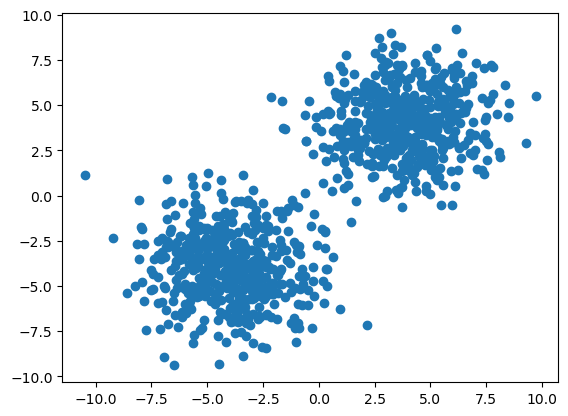

In [6]:
plt.scatter(points[0],points[1])

In [7]:
counts,xedges,yedges=np.histogram2d(points[0],points[1],bins=(numbinsx,numbinsy))

In [8]:
#xedges

In [9]:
#yedges

In [10]:
deltax=xedges[1]-xedges[0]
deltay=yedges[1]-yedges[0]

In [11]:
binarea=deltax*deltay

In [12]:
density=counts/binarea

In [13]:
density.shape

(16, 16)

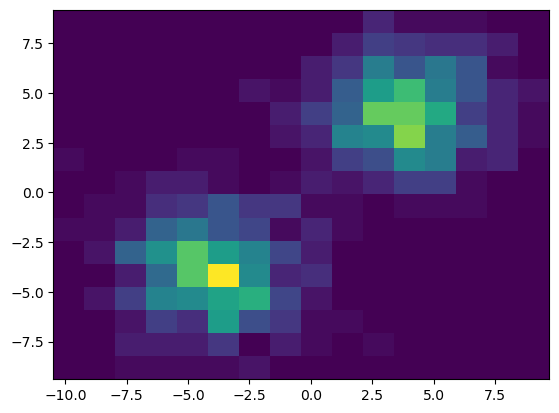

In [14]:
plt.hist2d(points[0],points[1],bins=[xedges,yedges])
plt.show()

In [15]:
fftdensity=fft.fft2(density)

In [16]:
#fftdensity

In [17]:
fftdensity.shape

(16, 16)

In [18]:
k=fft.fftfreq(numbinsx,deltax)
l=fft.fftfreq(numbinsy,deltay)

In [19]:
l

array([ 0.        ,  0.05381244,  0.10762488,  0.16143732,  0.21524976,
        0.26906219,  0.32287463,  0.37668707, -0.43049951, -0.37668707,
       -0.32287463, -0.26906219, -0.21524976, -0.16143732, -0.10762488,
       -0.05381244])

according to this https://atmos.washington.edu/~breth/classes/AM585/lect/FS_2DPoisson.pdf, instead of dividing by k^2, divide by k^2+l^2 where k and l correspond to the coordinates of the cell

In [21]:
fftpotential=np.zeros((numbinsx,numbinsy),dtype=complex)

In [22]:
for i in range(numbinsx):
    for j in range(numbinsy):
        if k[i]==0 and l[j]==0:
            fftpotential[i,j]=0
        else:
            fftpotential[i,j]=-fftdensity[i,j]/(k[i]**2+l[j]**2)

In [23]:
potential=np.fft.ifft2(fftpotential) 

In [24]:
#potential #woohoo no more complex parts so that means the ks and ls were the correct values
#note - the complex parts were zero when using only 4x8 bins
#with more bins they are nonzero but seem like truncation error because the order of magnitude
#is around 10 to the -14 to 17

In [25]:
potential=potential.real

In [26]:
potentialghosts=np.pad(potential, pad_width=1, mode='edge')

now... how to compute the gradient in 2d? hmm - can just use numpy gradient method or look up 2d centered difference method
https://numpy.org/doc/stable/reference/generated/numpy.gradient.html

In [28]:
gradx,grady=np.gradient(potentialghosts, deltax, deltay)

In [29]:
#grady

In [30]:
vt0=np.zeros((2,numpoints))

In [31]:
vt1=np.zeros((2,numpoints))

In [32]:
xlabels=np.digitize(points[0,:].round(5),xedges.round(5),right=True)

In [33]:
ylabels=np.digitize(points[1,:].round(5),yedges.round(5),right=True)

In [34]:
deltat=0.1 #had to make deltat really small or points just went everywhere right away
#because of the instability issue with this method

In [35]:
for i in range(numpoints):
    ixbin=xlabels[i]
    iybin=ylabels[i]
    vt1[0,i]=vt0[0,i]-deltat*gradx[ixbin,iybin] #update velocity by adding acceleration (negative potential gradient times deltat)
    vt1[1,i]=vt0[1,i]-deltat*grady[ixbin,iybin] 
#would work better with leapfrog method for calculating velocities

In [36]:
#vt1

In [37]:
points=points+vt1*deltat

In [38]:
#points

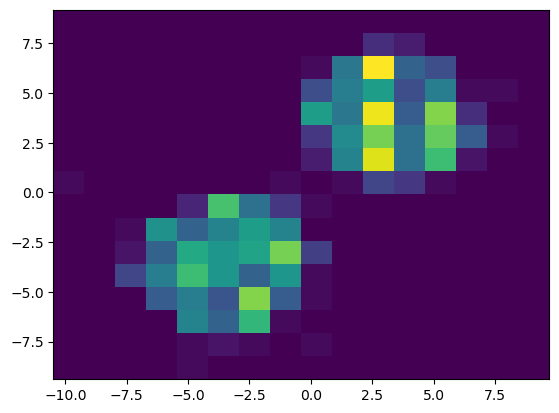

In [39]:
plt.hist2d(points[0,:],points[1,:],[xedges,yedges])
plt.show()